<a href="https://colab.research.google.com/github/ammarali0416/CAP6415/blob/main/CV_Module_4_4_2D_Nonlinear_Estimation_and_RANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Topics Covered

* You will learn about the **RANdom SAmple Consensus (RANSAC)** algorithm that is very effective for fitting in the presence of outliers.

* You will learn that all linear transforms cannot be estimated using linear methods. You will get familiar with **linear transforms that are non-linear with respect to their parameters**.

* You will learn about two simple ways for non-linear least squares estimation: gradient descent, which we use for training deep neural networks, and the Newton method, which also uses second derivatives (Hessian) to speed up convergence.

* You will see how we can use PyTorch's autograd function for gradient descent and Newton's estimation of non-linear transformations.


**Concepts learned:** RANSAC, non-linear estimation, gradient descent, Hessian, Newton (Newton-Raphson) method, pytorch, autograd



# 1. **Ran**dom **Sa**mple **C**onsensus (RANSAC)

Random Sample Consensus (RANSAC) is a method to fit a model to the observed data points in the presence of outliers.

RANSAC was proposed in 1981 by Fischler and Bolles (M.A. Fischler and R.C. Bolles: _[Random sample consensus: A paradigm for model fitting with applications to image analysis and automated cartography](http://www.cs.ait.ac.th/~mdailey/cvreadings/Fischler-RANSAC.pdf)_. Communications of the ACM, 24(6):381–395, 1981).

## 1.1 Algorithm


> 1. Randomly select the minimum number of corresponding pairs required to determine the model parameters.
> 2. Estimate the parameters of the model.
> 3. Determine **inliers** -- how many points from the set of all points are within an acceptable error/residual.
> 4. Keep track of the sample that results in the maximum number of inliers.
> 5. Repeat steps 1 through 5 ($N$ times).
> 6. Re-estimate the model parameters using the best inliers set and terminate.

### How do we choose $N$?

* Let $m$ be the number of data points randomly sampled in each iteration.
* Let $p$ be the probability that at least one sample does not contain an outlier. Usually, this is set to 0.99.
* Let $u$ be the probability that we have an inlier in the dataset -- a rough estimate of the fraction of inliers in the dataset.

Then, $N$ is given by $$N = \frac{\log(1 − p)}{\log(1 − u^m)}$$


## 1.2 Illustration

[]

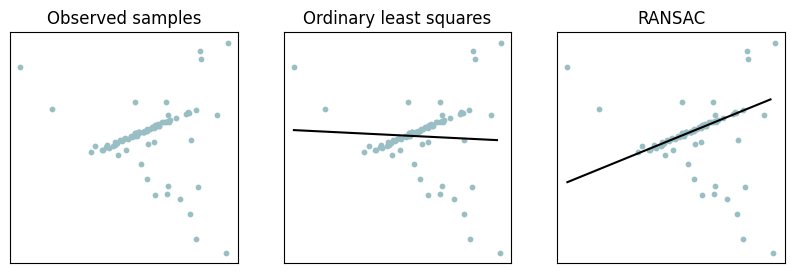

In [1]:
import numpy as np
from matplotlib import pyplot as plt


def generate_samples():
    num_inliers = 50
    num_outliers = 30

    # points roughly along a line
    points_on_a_line = lambda m, x, c, noise=0.05: m * x + c + np.random.uniform(0, noise, x.shape)

    x = np.random.normal(0.5, 0.25, (num_inliers))
    x_noise = np.random.normal(0.5, 0.5, (num_outliers))

    y = points_on_a_line(np.tan(10), x, 0)
    y_noise = x_noise * np.random.normal(0, 1, (num_outliers))

    x = np.concatenate((x, x_noise))
    y = np.concatenate((y, y_noise))

    return x, y


def ordinary_least_squares(x, y):
    p = x - np.mean(x)
    q = y - np.mean(y)

    # compute the parameters
    w = ((p @ q.transpose()) / (p ** 2).sum())
    b = ((np.mean(y) - w * np.mean(x)))

    return w, b


def ransac(x, y, num_samples=10, success_threshold=0.1, num_iterations=50):
    loss = 1e9
    best_inliers = {'x': np.empty(0), 'y': np.empty(0)}

    for _ in range(num_iterations):
        # step 1: sample some observations at random
        idxs = np.random.choice(np.arange(x.size), num_samples, replace=False)
        x_samples, y_samples = x[idxs], y[idxs]

        # step 2: make an initial guess (i.e., "fit" the model)
        w_potential, b_potential = ordinary_least_squares(x_samples, y_samples)

        # step 3: test the guess (i.e., (Monte Carlo) cross-validate the model)
        # against all the observations and determine potential inliers
        potential_loss = ((w_potential * x + b_potential) - y) ** 2
        potential_inliers_idx = potential_loss < success_threshold

        # step 4: if the test suggests that the guess satisfies most
        # observations, and if the current guess is better than previous
        # guesses (smaller loss, more samples in consensus, etc.), then
        # update this as the best guess so far
        if potential_inliers_idx.size > best_inliers['x'].size:
            potential_x = x[potential_inliers_idx]
            potential_y = y[potential_inliers_idx]

            loss_current = ((w_potential * potential_x + b_potential -
                             potential_y) ** 2).sum()
            if loss_current < loss: # or use an acceptable error hyperparameter
                loss = loss_current
                best_inliers['x'] = potential_x
                best_inliers['y'] = potential_y

    # re-estimate the parameters with the best inliers and return the model
    return ordinary_least_squares(best_inliers['x'], best_inliers['y'])

np.random.seed(42)

# samples
x, y = generate_samples()

# ordinary least squares
m1, c1 = ordinary_least_squares(x, y)
x1 = np.arange(x.min(), x.max(), 0.05)
y1 = m1 * x1 + c1

# RANSAC
m2, c2 = ransac(x, y)
y2 = m2 * x1 + c2

# plots
plt.style.use('default')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
ax[0].scatter(x, y, c='#99bfc4', s=10)
ax[0].set_title('Observed samples')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].scatter(x, y, c='#99bfc4', s=10)
ax[1].plot(x1, y1, c='black')
ax[1].set_title('Ordinary least squares')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].scatter(x, y, c='#99bfc4', s=10)
ax[2].plot(x1, y2, c='black')
ax[2].set_title('RANSAC')
ax[2].set_xticks([])
ax[2].set_yticks([])

## 1.3 Applications

* Modelling distributions while being robust to outliers
* Detect inliers; conversely reject outliers

*Given a set of keypoint features between a pair of images of an object, detect inliers and reject outliers using RANSAC.*

* Let $m$ be the minimum number of data points needed to estimate a transformation. For instance, for affine transformation, we need $m=3$ corresponding pairs of points as we have 6 unknowns, and each corresponding pair gives us two equations.

* We repeatedly (i) create 3-corresponding pair (matches) samples, (ii) estimate the affine transform, and (iii) compute the fit on the pairs left out from the 3-pair sample.
* The final solution is the one with the best fit.


# Initialize notebook

In [2]:
# Mount drive. Note - we can also mount the drive using one of the icon options available
# from the folder icon on the left.
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Colab Notebooks/CAP 6415 Computer Vision Online/data/'

!ls "$data_dir"

Mounted at /content/drive
 0005_Walking001.xlsx			     house_2.png	 mountain_peak_1.png
 0008_ChaCha001.xlsx			     house_facade.png	 mountain_peak_2.png
 2011_09_26_drive_0048_sync		     images.zip		 parking_lot_meva_1.png
 2011_09_26_drive_0048_sync.zip		     IMG_0185.jpg	 parking_lot_meva_2.png
 20211003_082148.jpg			     IMG_0186.jpg	 parking_lot_meva_3.png
 20211003_082201.jpg			     kellog.jpg		'potato_box&other.png'
 apple.jpg				     left01.jpg		 potato_box.png
'Armes 1.png'				     left02.jpg		'Road Signs Kaggle'
'Armes 2.png'				     left03.jpg		'Road Signs Kaggle.zip'
 blog_danforth_monica_mural_panorama.jpg     left04.jpg		 semper
 blog_monica_mural_brown_white.jpg	     left05.jpg		 semper.zip
 blog_monica_mural_fish_tree_windows1.jpg    left06.jpg		'Superbowl 2021_1.png'
'cats and dogs.jpg'			     left07.jpg		'Superbowl 2021_2.png'
 convenience-store-cereal01.jpg		     left08.jpg		'Superbowl 2021_3.png'
 declaration_of_independence_stone_630.jpg   left09.jpg		 Total-Text-D

In [3]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import scipy.ndimage as scimage
from skimage.transform import warp
import torch.nn as nn
from skimage import io

# Installing the version of OpenCV that has SIFT
!pip install opencv-contrib-python==4.4.0.44
import cv2
print (cv2 .__version__)

np.set_printoptions(precision=2, suppress=True)
torch.set_printoptions(precision=2, sci_mode=False)

ERROR: Could not find a version that satisfies the requirement opencv-contrib-python==4.4.0.44 (from versions: 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82)
ERROR: No matching distribution found for opencv-contrib-python==4.4.0.44
4.8.0


## Code: Detect and match SIFT keypoints between two images

In [4]:
def detect_and_match_keypoints (image_1, image_2) :
    # input are just two images
    # returns SIFT key points and descriptors for each image along with sorted match list (plus pairs of point matching coordinates)
    # SIFT with default parameters
    sift = cv2.SIFT_create(nOctaveLayers = 3, contrastThreshold = 0.04, edgeThreshold = 10, sigma = 1.6)

    keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image_2, None)

    # FEATURE MATCHING
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    matches = bf.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)
    X_1 = []
    X_2 = []
    for i in range(len(matches)) :
        X_1.append([keypoints_1[matches[i].queryIdx].pt[0], keypoints_1[matches[i].queryIdx].pt[1]])
        X_2.append([keypoints_2[matches[i].trainIdx].pt[0], keypoints_2[matches[i].trainIdx].pt[1]])
    X_1 = np.array(X_1)
    X_2 = np.array(X_2)

    return(X_1, X_2, keypoints_1, keypoints_2, matches)

## Code: SIFT keypoint detection and matching

In [5]:
image_1 = io.imread('https://i.stack.imgur.com/Er7vx.png')
image_2 = io.imread('https://i.stack.imgur.com/gAz96.png')

#image_1 = io.imread(data_dir+'Road Signs Kaggle/images/road153.png')
#image_2 = io.imread(data_dir+'Road Signs Kaggle/images/road824.png')

#image_1 = io.imread(data_dir+'kellog.jpg')
#image_2 = io.imread('https://c7.alamy.com/comp/J6T86H/boxes-of-rice-krispies-and-raisin-bran-cereal-on-shelves-at-a-grocery-J6T86H.jpg')


image_1 = cv2.cvtColor(image_1, cv2.COLOR_RGB2BGR) # change from scikit RGB to cv2 BGR format for color images
image_2 = cv2.cvtColor(image_2, cv2.COLOR_RGB2BGR)
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY) # change from color to gray
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

X_1, X_2, keypoints_1, keypoints_2, matches = detect_and_match_keypoints (image_1, image_2)
num_matches = 40 # select only the best num_matches matches
X_1 = X_1[:num_matches,:]
X_2 = X_2[:num_matches,:]

#----------------------------------Display-------------------------------------------------------
# draw matches
match_image = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, matches[:num_matches], image_2, flags=2)

plt.figure(figsize=(40,20))
plt.subplot(221)
plt.imshow(image_1, 'gray')
plt.plot(X_1[:,0], X_1[:,1], 'bo')
plt.subplot(222)
plt.imshow(image_2, 'gray')
plt.plot(X_2[:,0], X_2[:,1], 'ro')
plt.subplot(212)
plt.imshow(match_image);

HTTPError: HTTP Error 403: Forbidden

## Code: QR based inverse computation (see lecture on Linear (Affine) Estimation)

In [6]:
def qr_solve (H, b) :
    # H is n by n matrix, b is a n by 1 vector
    # returns a n by 1 vector as a solution

    Q, R = np.linalg.qr(H, 'reduced')
    b_dash = Q.transpose(1,0) @ b
    Np = b_dash.shape[0]
    del_p = np.zeros((Np, 1))
    for i in range(Np-1, -1, -1): # work from the last row of R
        sum_r_p = [0]
        for j in range(i+1, Np, 1) :
            sum_r_p += R[i, j]*del_p[j]
        if (R[i,i] != 0.0):
            del_p[i] = (b_dash[i]- sum_r_p)/R[i,i]

    return(del_p)

## Code: Affine fitting to point sets

In [7]:
def fit_affine (X, X_dash, select_flag) :
    # input: two 2D points sets, 3 by N arrays of homogeneous representation of the points
    # select_flag: 1D array of 0 an 1 indicating which points to use in the estimation.
    # output: residual of fit and the best fitting affine transformation

    # Compute the matrix H from the point coordinate moments
    M = X @ np.diag(select_flag) @ X.transpose(1,0)
    H1 = np.column_stack((M, np.zeros((3,3))))
    H2 = np.column_stack((np.zeros((3,3)), M))
    H = np.row_stack((H1, H2))

    # vector b
    b_dash = X @ np.diag(select_flag) @(X_dash - X).transpose(1,0)
    b = np.row_stack((b_dash[:,0][:,None], b_dash[:,1][:,None]))

    p = qr_solve (H, b)

    p = p.squeeze()
    # the parameter vector is [a_00, a_01, t_x, a_10, a_11, t_y]
    # rearrange it back into homogeneous matrix representation
    # do not forget to add in the identity matrix. We used the (1+a_ii) parameterization
    T_affine = np.row_stack((p.reshape(2, 3), [0, 0, 0])) + np.eye(3)

    X_t = T_affine @ X

    # If you want to return the total (summed) squared residual use the following
    #residual_error = np.sum(np.power((X_dash - X_t)*select_flag, 2))

    # If you want residual error per matching point in terms of pixels
    residual_error = np.sum(np.power(X_dash - X_t, 2)*select_flag)
    residual_error = np.sqrt(residual_error/np.sum(select_flag))

    return(residual_error, T_affine)


# Youtube Video -- example using fitting 2D lines to points (8 min)

https://www.youtube.com/watch?v=9D5rrtCC_E0


# Code: number of interations

In [8]:
def ransac_N(m=4, u=0.3, p=0.99) :
    #m: minimum number of data units needed to estimate
    #u: what fraction of data are inliers
    #p: how confident we want to be in our estimate

    N = np.log(1 - p)/np.log(1 - np.power(u, m))
    return(int(N))

print('If each sample has {} data units, we need {} samples'.format(3, ransac_N(m=3, u=0.20, p=0.99)))

If each sample has 3 data units, we need 573 samples


## Code: Detect inliers

In [9]:
def detect_intliers (X, X_dash, Transform, acceptable_error = 2) :
    # input: two 2D points sets, 3 by N arrays of homogeneous representation of the points
    # Transform: estimated transform matrix to use to detect inliers.
    # acceptable_error - amount of average pixel error that is acceptable for inliers
    # output is an 1D array of size equal to the number of points, N, with 0 or 1,
    #        with 1 indicating the corresponding point is an inlier

    X_t = Transform @ X
    X_t = np.divide(X_t, X_t [2,:]) # normalized homogenous coordinates
    X_dash = np.divide(X_dash, X_dash [2,:]) # normalized homogenous coordinates

    error =  (X_dash - X_t)
    residual_error = np.sum(np.power(error, 2), axis=0)
    inliers  = np.where(residual_error < (acceptable_error*acceptable_error), 1, 0)

    return(inliers)


## Code: RANSAC

In [10]:
def ransac_fit (Points_1, Points_2, fit_function, acceptable_error = 2, min_samples=3, fraction_inlier = 0.05) :
    # input: two 2D points sets, each of size N by 2
    # fit_function: a function that computes the best fit, e.g. affine_fit
    # acceptable_error - amount of average pixel error that is acceptable
    # min_samples: number of samples per iteration
    # fraction_inlier: what fraction of the data are inliers
    # outputs: residual error, the best inlier flags, and the best fitting transformation

    # Rearrange the N by 2 sized points variable into 3 by N arrays of homogeneous representation of the points
    X = np.row_stack((Points_1.transpose(1,0), np.ones((1, Points_1.shape[0]))))
    X_dash = np.row_stack((Points_2.transpose(1,0), np.ones((1, Points_2.shape[0]))))

    N = X.shape[1]
    best_inliers = np.zeros((N,))
    N_ransac = ransac_N(m=min_samples, u=fraction_inlier, p=0.99)
    print('Repeating RANSAC {} times'.format(N_ransac))
    for i in range(N_ransac) :
        indices = np.random.choice(range(N), min_samples, replace=False)
        selected_pts = np.zeros((N,))
        selected_pts[indices] = 1
        residual_error, transform = fit_function (X, X_dash, selected_pts)
        inliers = detect_intliers (X, X_dash, transform, acceptable_error)
        if (np.sum(inliers) > np.sum(best_inliers)) :
            best_inliers = inliers
            transform_best = transform
            print('inlier:', np.sum(best_inliers), 'of ', N)

    selected_pts = np.zeros((N,))
    selected_pts[np.nonzero(best_inliers)] = 1
    residual_error, transform_best = fit_function (X, X_dash, selected_pts)
    return(residual_error, best_inliers, transform_best)

## Code: RANSAC used to reject outliers in correspondences

In [11]:
from skimage.transform import warp

#------------------------------------------------------------------------------
residual_error, selected_matches, T_affine = ransac_fit(X_1, X_2, fit_affine, acceptable_error=6, min_samples=3, fraction_inlier = 0.2)
#------------------------------------------------------------------------------

T_affine_inv = np.linalg.inv(T_affine)
print('Matches={}\n Average residual error={} pixels, \nT =\n{}\n T_inv =\n{}'.format(selected_matches, residual_error, T_affine, T_affine_inv))

warped_1_into_2 = warp(image_1, inverse_map=T_affine_inv, output_shape=image_2.shape)

warped_2_into_1 = warp(image_2, inverse_map=T_affine, output_shape=image_1.shape)

# build an RGB image with the registered images -- should be white if match is perfect
seq_im_1_into_2 = np.zeros((image_2.shape[0], image_2.shape[1], 3))
seq_im_1_into_2[..., 0] = warped_1_into_2
seq_im_1_into_2[..., 1] = image_2/255
seq_im_1_into_2[..., 2] = image_2/255

seq_im_2_into_1 = np.zeros((image_1.shape[0], image_1.shape[1], 3))
seq_im_2_into_1[..., 0] = warped_2_into_1
seq_im_2_into_1[..., 1] = image_1/255
seq_im_2_into_1[..., 2] = image_1/255


plt.figure(figsize = (20, 20))
plt.subplot(3,3,1)
plt.imshow(image_1, 'gray')
plt.title('Image 1 (from image)')

plt.subplot(3,3,2)
plt.imshow(warped_2_into_1, 'gray')
plt.title('Image 2 mapped to register with Image 1')

plt.subplot(3,3,3)
plt.imshow(seq_im_2_into_1, 'gray')
plt.title('Color image create with Image 1 and remapped Image 2')


plt.subplot(3,3,4)
plt.imshow(image_2, 'gray')
plt.title('Image 2 (to image)')

plt.subplot(3,3,5)
plt.imshow(warped_1_into_2, 'gray')
plt.title('Image 1 mapped to register with Image 2')

plt.subplot(3,3,6)
plt.imshow(seq_im_1_into_2, 'gray')
plt.title('Color image create with Image 2 and remapped Image 1');


#----------------------------------Display-------------------------------------------------------
# draw matches
s_matches = np.array(matches)  # only arrays allow for multiple indices

s_matches = s_matches[np.nonzero(selected_matches)]

match_image = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, list(s_matches), image_2, flags=2)


plt.subplot(313)
plt.imshow(match_image);

NameError: name 'X_1' is not defined

# 2. Linear transformations that are non-linear with respect to the parameters

1. **2D rigid rotation with translation:** The residual is not a linear function of the rotation parameter, $\theta$.

\begin{eqnarray}
    \mathbf{r}_i & = & f (\tilde{\mathbf{x_i}}; \mathbf{p}) - \tilde{\mathbf{x_i}}'\\
    & = &
    \begin{bmatrix}
        \cos \theta & - \sin \theta & t_x \\
        \sin \theta & \cos \theta & t_y \\
        0  & 0 & 1
    \end{bmatrix}
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix} -
    \begin{bmatrix}
        x_i' \\ y_i' \\ 1
    \end{bmatrix}\\
\end{eqnarray}
   
>> The parameter vector is three-dimensional and is given by $\mathbf{p} =
\begin{bmatrix}
    t_x & t_y & \theta
\end{bmatrix}^T$. Note that we get the identity transformation with $\mathbf{p} = \begin{bmatrix}
 0 & 0 & 0
\end{bmatrix}^T$.


2. **2D Perspective (Homography) transformation**

>> Recall that we can represent the perspective transformation as
    
\begin{eqnarray}
    \begin{bmatrix}
        a \\ b \\ c
    \end{bmatrix} & = &
    \begin{bmatrix}
        h_{00} & h_{01} & h_{02}\\
        h_{10} & h_{11} & h_{12} \\
        h_{20} & h_{21} & h_{22}
    \end{bmatrix}
    \begin{bmatrix}
        x \\ y \\ 1
    \end{bmatrix}  \\
    \tilde{\mathbf{x}'} & = & \tilde{\mathbf{H}} \tilde{\mathbf{x}} \\
    \mathbf{x}' =
    \begin{bmatrix}
    x' \\ y'
    \end{bmatrix}
    & = &
    \begin{bmatrix}
        a/c \\ b/c
    \end{bmatrix}
\end{eqnarray}
    
>> Note that scaling of the transformation matrix, $\tilde{\mathbf{H}} $, results in the same point $\mathbf{x}'$. Thus the transformation matrix can be known only up to a scale. Another aspect of this transformation is that there is an infinite number of solutions. To constrain the solution space, we can fix **one** of the transformation matrix parameters to a constant value. Typically, this is $h_{22}$, which we set to 1. This condition, along with reparameterization of the transformation so that $\mathbf{p} = \mathbf{0}$ is the identity transformation, we arrive at the following effective representation of the transformation.

\begin{eqnarray}
    \begin{bmatrix}
        a \\ b \\ D
    \end{bmatrix} & = &
    \begin{bmatrix}
        1+h_{00} & h_{01} & h_{02}\\
        h_{10} & 1+h_{11} & h_{12} \\
        h_{20} & h_{21} & 1
    \end{bmatrix}
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix}  \\
    \mathbf{\hat{x}}' = \begin{bmatrix} \hat{x}_i' \\ \hat{y}_i' \end{bmatrix}
    & = &
    \begin{bmatrix}
        a/D \\ b/D
    \end{bmatrix}
\end{eqnarray}
    
    
>>The parameter vector is eight-dimensional and is given by  

\begin{equation}
\mathbf{p} =  
\begin{bmatrix}
    h_{00} & h_{01} & \cdots & h_{21}
\end{bmatrix}^T
\end{equation}

# 2.1 Linear methods cannot model functions non-linear in their parameters: illustration

Consider a dataset of four points and their targets:

| Input | Label |
| ----- | ----- |
| 0, 0  | 0 (orange) |
| 0, 1  | 1 (green) |
| 1, 0  | 1 (green) |
| 1, 1  | 0 (orange) |

This is visualised below ([source](https://www.niser.ac.in/~smishra/teach/cs460/2020/lectures/lec19/)):

![xor](https://www.niser.ac.in/~smishra/teach/cs460/2020/lectures/lec19/Graph.jpg)

A linear layer can never separate this data into two classes or attempt to regress the class id. But let us try anyway.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm

random.seed(42)
torch.random.manual_seed(42)

# define the data
data = torch.tensor([
  [0.0, 0.0, 0.0],
  [0.0, 1.0, 1.0],
  [1.0, 0.0, 1.0],
  [1.0, 1.0, 0.0]
])


def get_batch(data, batch_size=1):
    batch = torch.stack([data[random.randint(0,len(data)-1)] for _ in range(batch_size)])
    return batch[:,:-1], batch[:,-1:]


# spoiler alert: ignore this function; it uses an optimisation mechanism which
# will be covered later
def train_my_model(model):
  epochs = 10000
  lr = 1e-1

  optim = torch.optim.SGD(model.parameters(), lr = lr)

  for _ in tqdm(range(epochs)):

      x, y = get_batch(data, 3)
      a = model(x)
      loss = F.mse_loss(a, y)

      optim.zero_grad()
      loss.backward()
      optim.step()

  return model

In [13]:
# Linear Model
linear_model = nn.Sequential(
  nn.Linear(2, 2),
  nn.Linear(2, 1) # no use no matter how many linear layers you stack if just linear
)

train_my_model(linear_model)
with torch.no_grad():
  predictions = linear_model(data[:,:-1])
  print('Predictions:\n', torch.round(predictions, decimals=2).squeeze())
  print('Targets:\n', data[:,-1])

100%|██████████| 10000/10000 [00:06<00:00, 1564.98it/s]

Predictions:
 tensor([0.52, 0.51, 0.52, 0.51])
Targets:
 tensor([0., 1., 1., 0.])


In [14]:
# Non-Linear Model
nonlinear_model = nn.Sequential(
  nn. Linear(2, 2),
  nn.Tanh(),
  nn.Linear(2, 1),
  nn.Tanh()
)

train_my_model(nonlinear_model)
with torch.no_grad():
  predictions = nonlinear_model(data[:,:-1])
  print('Predictions:\n', torch.round(predictions, decimals=2).squeeze())
  print('Targets:\n', data[:,-1])

100%|██████████| 10000/10000 [00:07<00:00, 1348.66it/s]

Predictions:
 tensor([0.00, 0.98, 0.98, 0.00])
Targets:
 tensor([0., 1., 1., 0.])


# 2.2 Solution: Non-linear Least Squares methods

> 1. We start with an initial rough estimate $\mathbf{p_0}$, which could be $\mathbf{p_0} = \mathbf{0}$ but are best-fit affine parameters in practice.
> 2. Then we iteratively add increments, $\Delta \mathbf{p}$, to the parameters to minimize the residual at each step.

The following are some ways to solve non-linear optimization problems:

> 1. [Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent), a method from 1847, is used for backpropagation by deep learning methods.
> 2. [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) (a.k.a. the Newton–Raphson method) uses the second derivative (Hessian) and the gradient (Jacobian).
> 3. [Gauss-Newton method](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm), which we can only use to minimize a **sum of squared function values**, has the advantage that second derivatives are not needed.
> 4. [Levenberg–Marquardt algorithm](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) is used to solve non-linear least-squares problems and is the most commonly used stable approach that dynamically trades off between the Gauss-Newton approach and gradient descent.

* We experiment with gradient descent and the Newton approach here.

* The Newton method uses the second derivative (or Hessian) to compute its step sizes

* Gradient descent is very slow!



# Using Pytorch autograd feature to minimize errors

* torch.autograd is PyTorch's automatic differentiation engine that powers neural network training, but we can use it for other optimization purposes. We adapt it here to solve our perspective transformation fitting problem at hand.

> https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

> https://pytorch.org/tutorials/beginner/pytorch_with_examples.html?highlight=autograd

* Generally speaking, torch.autograd is an engine for computing **vector-Jacobian product**! Study the materials at the above links for more indepth understanding, if you so desire.

* Here is a link to Prof. Grosse's lecture on autodiff/autograd, which provides more technical information about how autograd works.

> https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf


Some important observations:

* "Conceptually, autograd keeps a record of data (tensors) & all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of Function objects. In this DAG, leaves are the input tensors, and roots are the output tensors. By tracing this graph from roots to leaves, you can **automatically compute the gradients using the chain rule.**"


* "**DAGs are dynamic in PyTorch** An important thing to note is that the graph is recreated from scratch; after each .backward() call, autograd starts populating a new graph. This is exactly what allows you to use control flow statements in your model; you can change the shape, size and operations at every iteration if needed."

* "torch.autograd tracks operations on all tensors which have their requires_grad flag set to True. For tensors that don't require gradients, setting this attribute to False excludes it from the gradient computation DAG."

* "The output tensor of an operation will require gradients even if only a single input tensor has requires_grad=True."

* "It is useful to "freeze" part of your model if you know in advance that you won't need the gradients of those parameters (this offers some performance benefits by reducing autograd computations)."


##Code: autograd example

Let $ Q = 3 \frac{{a}^3}{b^2}$

The partial derivatives with respect to $a$ and $b$ are:

\begin{eqnarray}
\frac{\partial}{\partial a} Q & = & 9 \frac{a^2}{b^2} \\
\frac{\partial}{\partial b} Q & = & -6 \frac{a^3}{b^3} \\
\end{eqnarray}

If we were to write code to compute these derivatives, we will have to first work out the analytical formulae for the derivatives (like above) and then code them into functions.

At $a=2$, and $b=2$ these derivatives have the following values:



In [15]:
a = 2.
b = 6.
Q_a = 9*a**2/(b**2)
Q_b = -6*a**3/(b**3)

print('Q_a = %3.2f'%(Q_a), ', Q_b = %3.2f'%(Q_b))
# See how we have formatted the outputs in python

Q_a = 1.00 , Q_b = -0.22



With autograd you do not have to work out the analytical expressions for the derivatives. It does it for you!

The following code computes the derivatives of the above expression at two different points: (a=2, b=6) and (a=3, b=4)

\begin{eqnarray}
\mathbf{a} & = & \begin{bmatrix} 2 & 3 \end{bmatrix} \\
\mathbf{b} & = & \begin{bmatrix} 6 & 4 \end{bmatrix} \\
\mathbf{q} & = & 3 \frac{\mathbf{a}^3}{\mathbf{b}^2} \\
\mathbf{Q} & = & \mathbf{q}\mathbf{1}^T
\end{eqnarray}

In [16]:
import torch
# A tensor (in the deep learning community) is a generalization of vectors and matrices.
# You can view it as a multidimensional array.
#
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)
Q = (3*a**3/b**2).sum()
# a and b to be parameters and Q to be the function to be minimized.

# When we call .backward() on Q, autograd calculates the gradient of Q with respect to a and b and
# stores them in the respective tensors’ .grad attribute.

Q.backward ()

# check if collected gradients are correct
print('Q_a: ', a.grad)
print('Q_b: ', b.grad)

Q_a:  tensor([1.00, 5.06])
Q_b:  tensor([-0.22, -2.53])


Autograd is especially useful when you have chained functions.

\begin{equation}
z = f(x, a) \\
y = g(z, b)
\end{equation}

where $a$ and $b$ are parameters. We are interested in the derivatives of $y$ with respect to $a$ and $b$: $\frac{\partial y}{\partial a}$ and $\frac {\partial y}{\partial b}$

We you were do this the old fashion way, you will have to derive expressions for these derivatives and then code them.

$\frac {\partial y}{\partial b}  = \frac {\partial g(z, b)}{\partial b}$

$\frac {\partial y}{\partial a}  = \frac {\partial y}{\partial z} \frac {\partial z}{\partial a} = \frac {\partial g(z, b)}{\partial z} \frac {\partial f(x, a)}{\partial a}$

Note the use of chain rule for the second one.

Consider the case when $f(x, a) = ax^2$ and $g(z, b) = b/z$

$\frac {\partial y}{\partial b}  = 1/z$

$\frac {\partial y}{\partial a}  = \frac {\partial y}{\partial z} \frac {\partial z}{\partial a} = \frac {\partial g(z, b)}{\partial z} \frac {\partial f(x, a)}{\partial a} = -(b/z^2)x^2$

Let us say we have to compute these derivatives at $x=2, a = 3, b = 4$. The following code is the traditional implementation of it.


## Code: chained function derivatives -- the old way

In [17]:
def f (x, a) :
    return (a*(x**2))

def g (z, b):
    return (b/z)

def z_deriv_a (x, a) :
    return(x*x)

def y_deriv_z (z, b) :
    return (-b/(z**2))

def y_deriv_b (z, b) :
    return (1/z)

x = 2
a = 3
b = 4
z = f(x, a)
print('y deriv a: %3.2f'%(y_deriv_z (z, b) * z_deriv_a (x, a)), '\ny deriv b:%3.2f'%(y_deriv_b (z, b)))

y deriv a: -0.11 
y deriv b:0.08


## Code: chained function derivatives using autograd

In [18]:
import torch

a = torch.tensor([3.], requires_grad=True)
b = torch.tensor([4.], requires_grad=True)
x = torch.tensor([2.], requires_grad=False)


def f (x, a) :
    return (a*(x**2))

def g (z, b):
    return (b/z)


y = g(f(x,a), b)

y.backward ()

# check if collected gradients are correct
print('y_a: %3.2f \ny_b: %3.2f'%(a.grad.item(), b.grad.item()))


y_a: -0.11 
y_b: 0.08


## Code: Non-linear estimation using pytorch.autograd (Newton's method)

In [20]:
from skimage.transform import warp
from skimage import io
import torch

dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0")  # Uncomment this to run on GPU

#-------------------------------------------------------------------------------
def fit_Newton_autograd (Input_points, Output_points, lr) :
    # Input_points, Output_points -- N by 2 sized arrays of (x, y) coordinates of points.

    # ------set up the input and output tensors -------------------------------
    # create homogeneous representation of input points (3 by N sized array)
    # and turn into torch tensors
    X1 = np.row_stack((Input_points.transpose(1,0), np.ones((1, Input_points.shape[0]))))
    X = torch.tensor(X1, device = device, requires_grad=False) # homogenous coordinates

    # torch tensor for the output points
    # (2 by N sized, do not need this to be homogemnous as we will not operate on them)
    X_dash = torch.tensor(Output_points.transpose(1,0), device = device, requires_grad=False) # non-homogenous coordinates

    h_22 = torch.tensor([0], device = device, requires_grad=False)
    # fixed entry of the homography matrix, need to treat it separately
    # as we will not be computing derivative with respect to it

    # ----------------------Compute initial estimate ----------------------------
    print('Performing affine fit with outlier detection to be used as initial parameters')
    av_residual, matches_selected, T_affine =  ransac_fit (Input_points, Output_points, fit_affine, acceptable_error=4)
    print('Average inlier error:', av_residual, '\nT_affine=\n', T_affine)
    matches_selected = torch.tensor(np.diag(matches_selected), dtype = float, device = device, requires_grad=False)

    # initialize the 8 parameters of the perspective transform matrix. Recall, h_22 = 0, hence only 8
    h_ = (T_affine - np.eye(3)).reshape(9,)[0:8]
    # we remove an identity matrix from T_affine as per parameterization convention (p=0, represents the identity matrix)
    h_8_est = torch.tensor(h_, device = device, requires_grad=True)
    #print('h = \n', h_8_est)

    #---------------define the loss function to be optimized-----------------------------
    def fit_error (h_8): # just 8 free parameters
        # Computes the fit error of 2D homography fit between X and X_dash using h_8 parameters
        # This is what we want to minimize by varying the h_8.
        # Uses variables defined outside of the function: X, X_dash, matches_selected

        H = torch.cat((h_8, h_22), 0)
        X_t = torch.matmul(H.reshape(3,3) + torch.eye(3, device = device), X)
        # the identity matrix addition is to keep the parameterization such that
        # h_8 = 0 results in an identity transformation.

        Xt_nh = torch.div(X_t, X_t [2,:]) # normalized homogenous coordinates
        Xt_nh = Xt_nh [0:2,:]

        Xloss =  (X_dash - Xt_nh) @ matches_selected

        return(torch.pow(Xloss, 2).sum())

    #-----------------------initialize the learning parameters----------------------------------------
    learning_rate = lr
    prev_residual = 99999.0
    exit_flag = False
    max_iterations = 1000
    t = 0
    #------------------------------------estimation iterations----------------------------------------
    while (exit_flag == False):

        Hessian = torch.autograd.functional.hessian(fit_error, h_8_est)
        # Note how we do have to derive mathematical expressions for the Hessian. Yeah!!

        residual = fit_error (h_8_est)/X.shape[1]
        # Residual is a Tensor of shape (1,)

        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        residual.backward()

        # Update weights using gradient descent.
        # Note we wrap the code in torch.no_grad() we do not need the
        # gradients computed for this piece of code
        with torch.no_grad():
            del_p = learning_rate * torch.inverse(Hessian) @ h_8_est.grad
            h_8_est -= del_p
            if prev_residual > residual.item() :
                prev_residual = residual.item() # *.item() gets the scalar value held.
            else :
                exit_flag = True
            if (np.remainder(t, 100) == 0) :
                print(t, np.sqrt(residual.item())) # *.item() gets the scalar value held.
                #print('h.grad = \n', torch.norm(h_8_est.grad), '\n del_p\n', torch.norm(del_p), '\n Hessian\n', torch.norm(Hessian))
            # Zero-out the gradients after updating weights
            h_8_est.grad = None
        t = t+1
        if (t > max_iterations) :
            exit_flag = True

    H = torch.cat((h_8_est, h_22), 0).reshape(3, 3) + torch.eye(3, device = device)

    return(torch.sqrt(residual), H.detach().cpu().numpy(), matches_selected)

## Code: pytorch.autograd based Newton estimation example

Performing affine fit with outlier detection to be used as initial parameters
Repeating RANSAC 36839 times
inlier: 5 of  100
inlier: 6 of  100
inlier: 8 of  100
inlier: 14 of  100
inlier: 15 of  100
Average inlier error: 1.7226026860517014 
T_affine=
 [[  0.44   0.07 113.12]
 [ -0.05   0.44 169.04]
 [  0.     0.     1.  ]]
0 0.6671611515210403
100 0.6608070272748445
200 0.6605028948371945
300 0.6604880687027359
400 0.6604873466983219
500 0.6604873115544416
600 0.660487309843987
700 0.6604873097607444
800 0.6604873097566887
Residual error=0.6604873097566899
 T =
[[  0.45   0.03 115.06]
 [ -0.04   0.4  171.02]
 [  0.    -0.     1.  ]]
 T_inv =
[[   2.24   -0.25 -215.  ]
 [   0.3     2.28 -424.81]
 [  -0.      0.      0.94]]


Text(0.5, 1.0, 'Color image create with Image 2 and remapped Image 1')

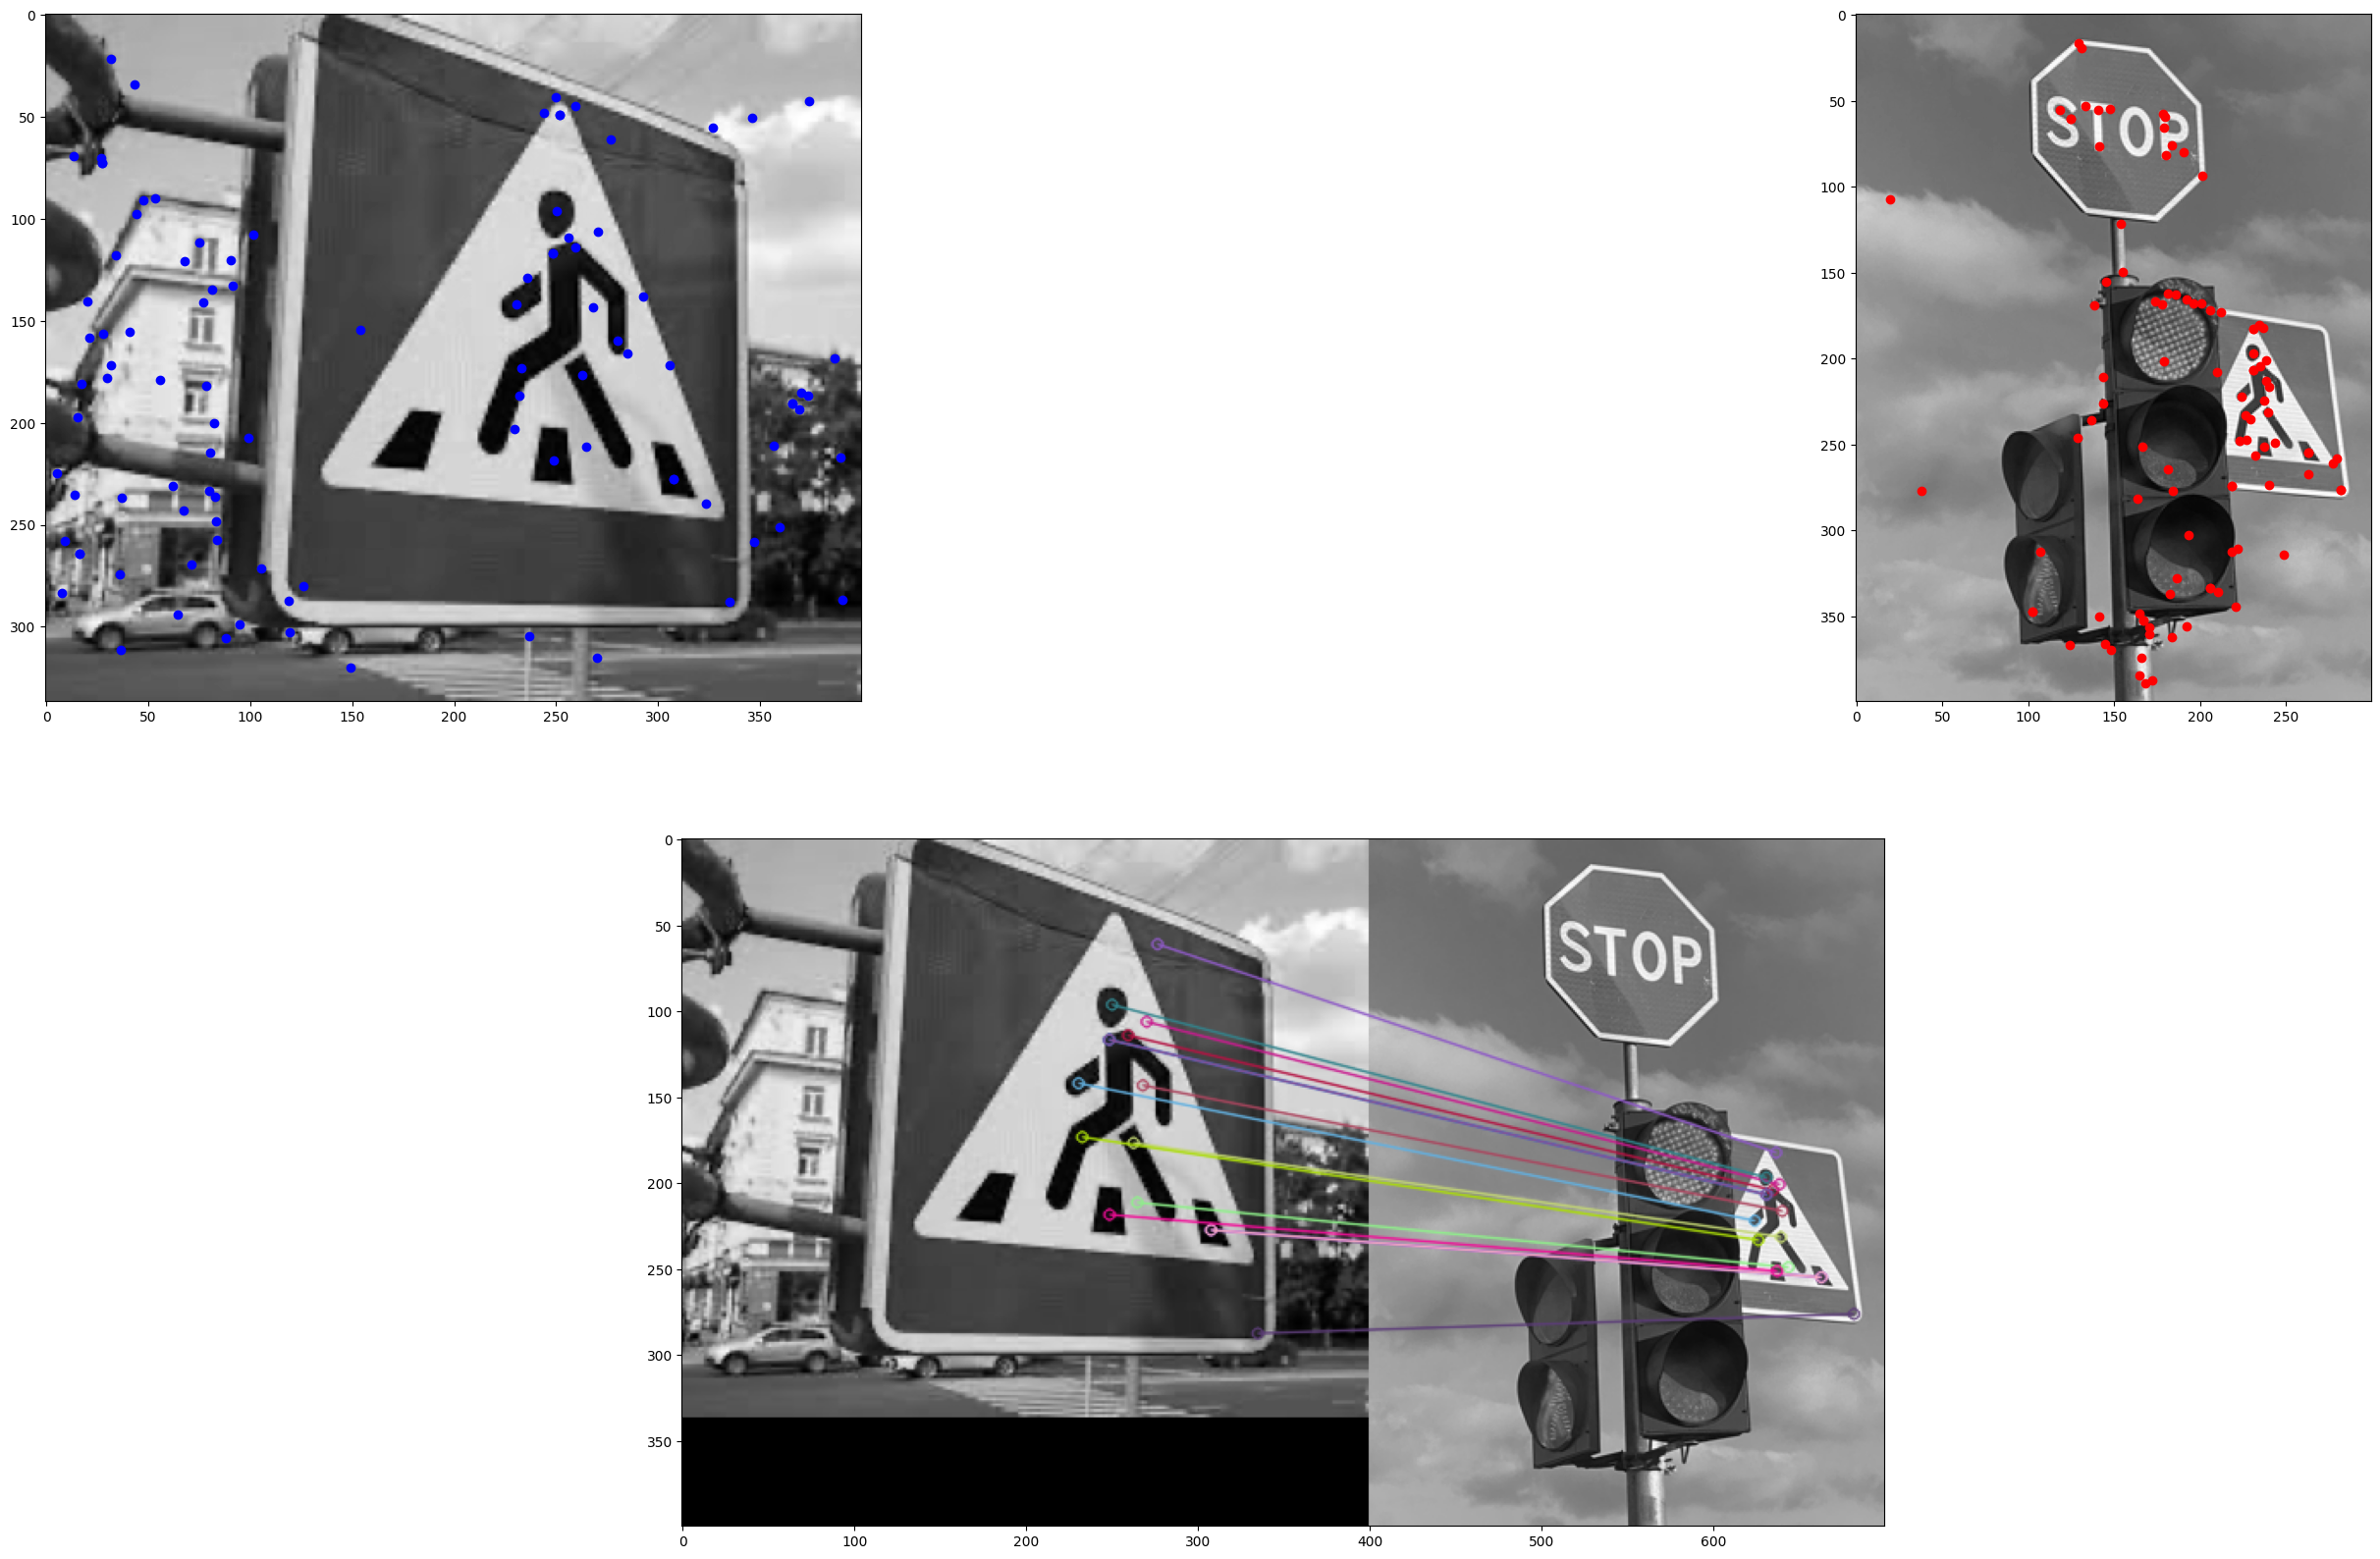

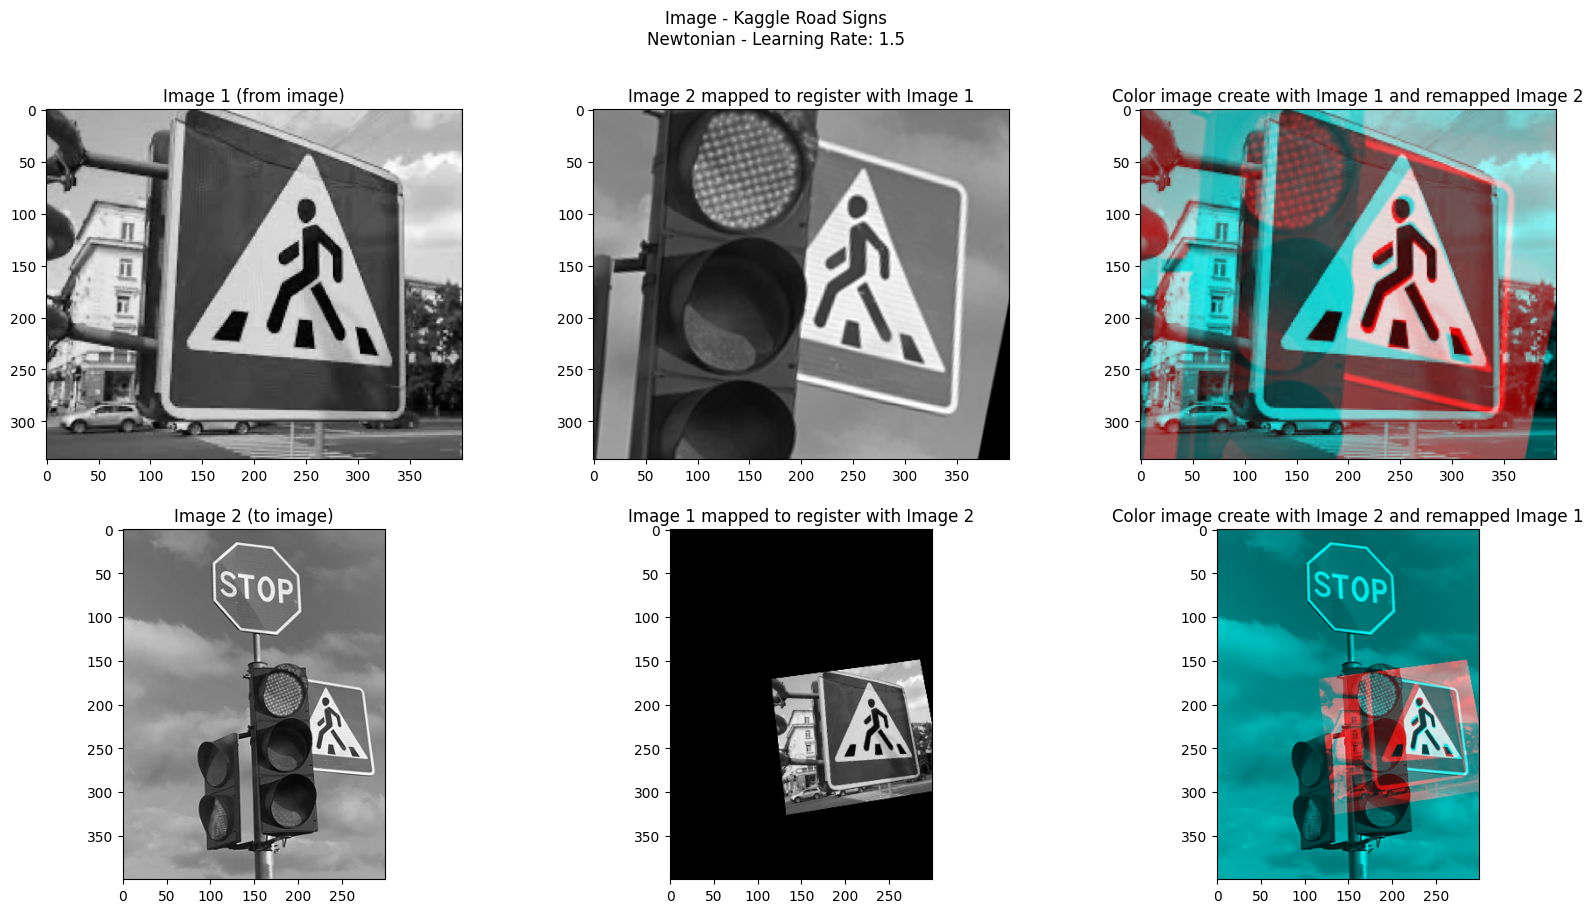

In [30]:
#image_1 = io.imread('https://i.stack.imgur.com/Er7vx.png')
#image_2 = io.imread('https://i.stack.imgur.com/gAz96.png')

image_1 = cv2.cvtColor(image_1, cv2.COLOR_RGB2BGR) # change from scikit RGB to cv2 BGR format for color images
image_2 = cv2.cvtColor(image_2, cv2.COLOR_RGB2BGR)
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY) # change from color to gray
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

X_1, X_2, keypoints_1, keypoints_2, matches = detect_and_match_keypoints (image_1, image_2)
top_matches = 100
X_1 = X_1[:top_matches,:]
X_2 = X_2[:top_matches,:]

learning_rate = 1.5

image_name = 'Kaggle Road Signs'
#-----------call to non linear fitting function-------------------
residual, T, matches_selected = fit_Newton_autograd (X_1, X_2, learning_rate)

#--------------------------------------------------------------

T_inv = np.linalg.inv(T)
print('Residual error={}\n T =\n{}\n T_inv =\n{}'.format(residual, T, T_inv))

warped_1_into_2 = warp(image_1, inverse_map=T_inv, output_shape=image_2.shape)

warped_2_into_1 = warp(image_2, inverse_map=T, output_shape=image_1.shape)


#----------------------------------Display-------------------------------------------------------
# draw matches
matches_selected = (np.where(matches_selected==1)[0])
matches_selected = np.take(matches, matches_selected)
match_image = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, matches_selected, image_2, flags=2)

plt.figure(figsize=(40,20))
plt.subplot(221)
plt.imshow(image_1, 'gray')
plt.plot(X_1[:,0], X_1[:,1], 'bo')
plt.subplot(222)
plt.imshow(image_2, 'gray')
plt.plot(X_2[:,0], X_2[:,1], 'ro')
plt.subplot(212)
plt.imshow(match_image)

# build an RGB image with the registered images -- should be white if match is perfect
seq_im_1_into_2 = np.zeros((image_2.shape[0], image_2.shape[1], 3))
seq_im_1_into_2[..., 0] = warped_1_into_2
seq_im_1_into_2[..., 1] = image_2/255
seq_im_1_into_2[..., 2] = image_2/255

seq_im_2_into_1 = np.zeros((image_1.shape[0], image_1.shape[1], 3))
seq_im_2_into_1[..., 0] = warped_2_into_1
seq_im_2_into_1[..., 1] = image_1/255
seq_im_2_into_1[..., 2] = image_1/255

plt.figure(figsize = (20, 10))
plt.suptitle(f'Image - {image_name}\nNewtonian - Learning Rate: {learning_rate}')
plt.subplot(2,3,1)
plt.imshow(image_1, 'gray')
plt.title('Image 1 (from image)')

plt.subplot(2,3,2)
plt.imshow(warped_2_into_1, 'gray')
plt.title('Image 2 mapped to register with Image 1')

plt.subplot(2,3,3)
plt.imshow(seq_im_2_into_1, 'gray')
plt.title('Color image create with Image 1 and remapped Image 2')


plt.subplot(2,3,4)
plt.imshow(image_2, 'gray')
plt.title('Image 2 (to image)')

plt.subplot(2,3,5)
plt.imshow(warped_1_into_2, 'gray')
plt.title('Image 1 mapped to register with Image 2')

plt.subplot(2,3,6)
plt.imshow(seq_im_1_into_2, 'gray')
plt.title('Color image create with Image 2 and remapped Image 1')


##Code: Gradient descent using autograd

In [22]:
from skimage.transform import warp
from skimage import io
import torch

dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0")  # Uncomment this to run on GPU

#-------------------------------------------------------------------------------
def fit_grad_descent_autograd (Input_points, Output_points, lr) :
    # Input_points, Output_points -- N by 2 sized arrays of (x, y) coordinates of points.

    # ------set up the input and output tensors -------------------------------
    # create homogeneous representation of input points (3 by N sized array)
    # and turn into torch tensors
    X1 = np.row_stack((Input_points.transpose(1,0), np.ones((1, Input_points.shape[0]))))
    X = torch.tensor(X1, device = device, requires_grad=False) # homogenous coordinates

    # torch tensor for the output points
    # (2 by N sized, do not need this to be homogemnous as we will not operate on them)
    X_dash = torch.tensor(Output_points.transpose(1,0), device = device, requires_grad=False) # non-homogenous coordinates

    h_22 = torch.tensor([0], device = device, requires_grad=False)
    # fixed entry of the homography matrix, need to treat it separately
    # as we will not be computing derivative with respect to it

    # ----------------------Compute initial estimate ----------------------------
    print('Performing affine fit with outlier detection to be used as initial parameters')
    av_residual, matches_selected, T_affine =  ransac_fit (Input_points, Output_points, fit_affine, acceptable_error=4)
    print('Average inlier error:', av_residual, '\nT_affine=\n', T_affine)
    matches_selected = torch.tensor(np.diag(matches_selected), dtype = float, device = device, requires_grad=False)

    # initialize the 8 parameters of the perspective transform matrix. Recall, h_22 = 0, hence only 8
    h_ = (T_affine - np.eye(3)).reshape(9,)[0:8]
    # we remove an identity matrix from T_affine as per parameterization convention (p=0, represents the identity matrix)
    h_8_est = torch.tensor(h_, device = device, requires_grad=True)
    #print('h = \n', h_8_est)

    #---------------define the loss function to be optimized-----------------------------
    def fit_error (h_8): # just 8 free parameters
        # Computes the fit error of 2D homography fit between X and X_dash using h_8 parameters
        # This is what we want to minimize by varying the h_8.
        # Uses variables defined outside of the function: X, X_dash, matches_selected

        H = torch.cat((h_8, h_22), 0)
        X_t = torch.matmul(H.reshape(3,3) + torch.eye(3, device = device), X)
        # the identity matrix addition is to keep the parameterization such that
        # h_8 = 0 results in an identity transformation.

        Xt_nh = torch.div(X_t, X_t [2,:]) # normalized homogenous coordinates
        Xt_nh = Xt_nh [0:2,:]

        Xloss =  (X_dash - Xt_nh) @ matches_selected

        return(torch.pow(Xloss, 2).sum())

    #-----------------------initialize the learning parameters----------------------------------------
    "changed the following"
    learning_rate = lr

    prev_residual = 99999.0
    exit_flag = False
    max_iterations = 1000
    t = 0
    #------------------------------------estimation iterations----------------------------------------
    while (exit_flag == False):

        "commented out the following as not needed for just gradient descent"
        # Hessian = torch.autograd.functional.hessian(fit_error, h_8_est)
        # Note how we do have to derive mathematical expressions for the Hessian. Yeah!!

        residual = fit_error (h_8_est)/X.shape[1]
        # Residual is a Tensor of shape (1,)

        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        residual.backward()

        # Update weights using gradient descent.
        # Note we wrap the code in torch.no_grad() we do not need the
        # gradients computed for this piece of code
        with torch.no_grad():
            "changed the following"
            # del_p = learning_rate * torch.inverse(Hessian) @ h_8_est.grad
            del_p = learning_rate * h_8_est.grad
            h_8_est -= del_p
            if prev_residual > residual.item() :
                prev_residual = residual.item() # *.item() gets the scalar value held.
            else :
                exit_flag = True
            if (np.remainder(t, 100) == 0) :
                print(t, np.sqrt(residual.item())) # *.item() gets the scalar value held.
                #print('h.grad = \n', torch.norm(h_8_est.grad), '\n del_p\n', torch.norm(del_p), '\n Hessian\n', torch.norm(Hessian))
            # Zero-out the gradients after updating weights
            h_8_est.grad = None
        t = t+1
        if (t > max_iterations) :
            exit_flag = True

    H = torch.cat((h_8_est, h_22), 0).reshape(3, 3) + torch.eye(3, device = device)

    return(torch.sqrt(residual), H.detach().cpu().numpy(), matches_selected)

## Code: pytorch.autograd based gradient-descent estimation example

Performing affine fit with outlier detection to be used as initial parameters
Repeating RANSAC 36839 times
inlier: 3 of  100
inlier: 4 of  100
inlier: 5 of  100
inlier: 9 of  100
inlier: 10 of  100
inlier: 11 of  100
inlier: 12 of  100
inlier: 14 of  100
inlier: 15 of  100
Average inlier error: 1.7329354354818778 
T_affine=
 [[  0.38   0.08 127.27]
 [ -0.03   0.44 161.24]
 [  0.     0.     1.  ]]
0 0.6711630081673995
Residual error=126.63724640770494
 T =
[[   0.3     0.49  127.27]
 [  -0.05    1.21  161.24]
 [-512.17   73.95    1.  ]]
 T_inv =
[[-0.34  0.27 -0.  ]
 [-2.38  1.88 -0.  ]
 [ 0.02 -0.01  0.  ]]


Text(0.5, 1.0, 'Color image create with Image 2 and remapped Image 1')

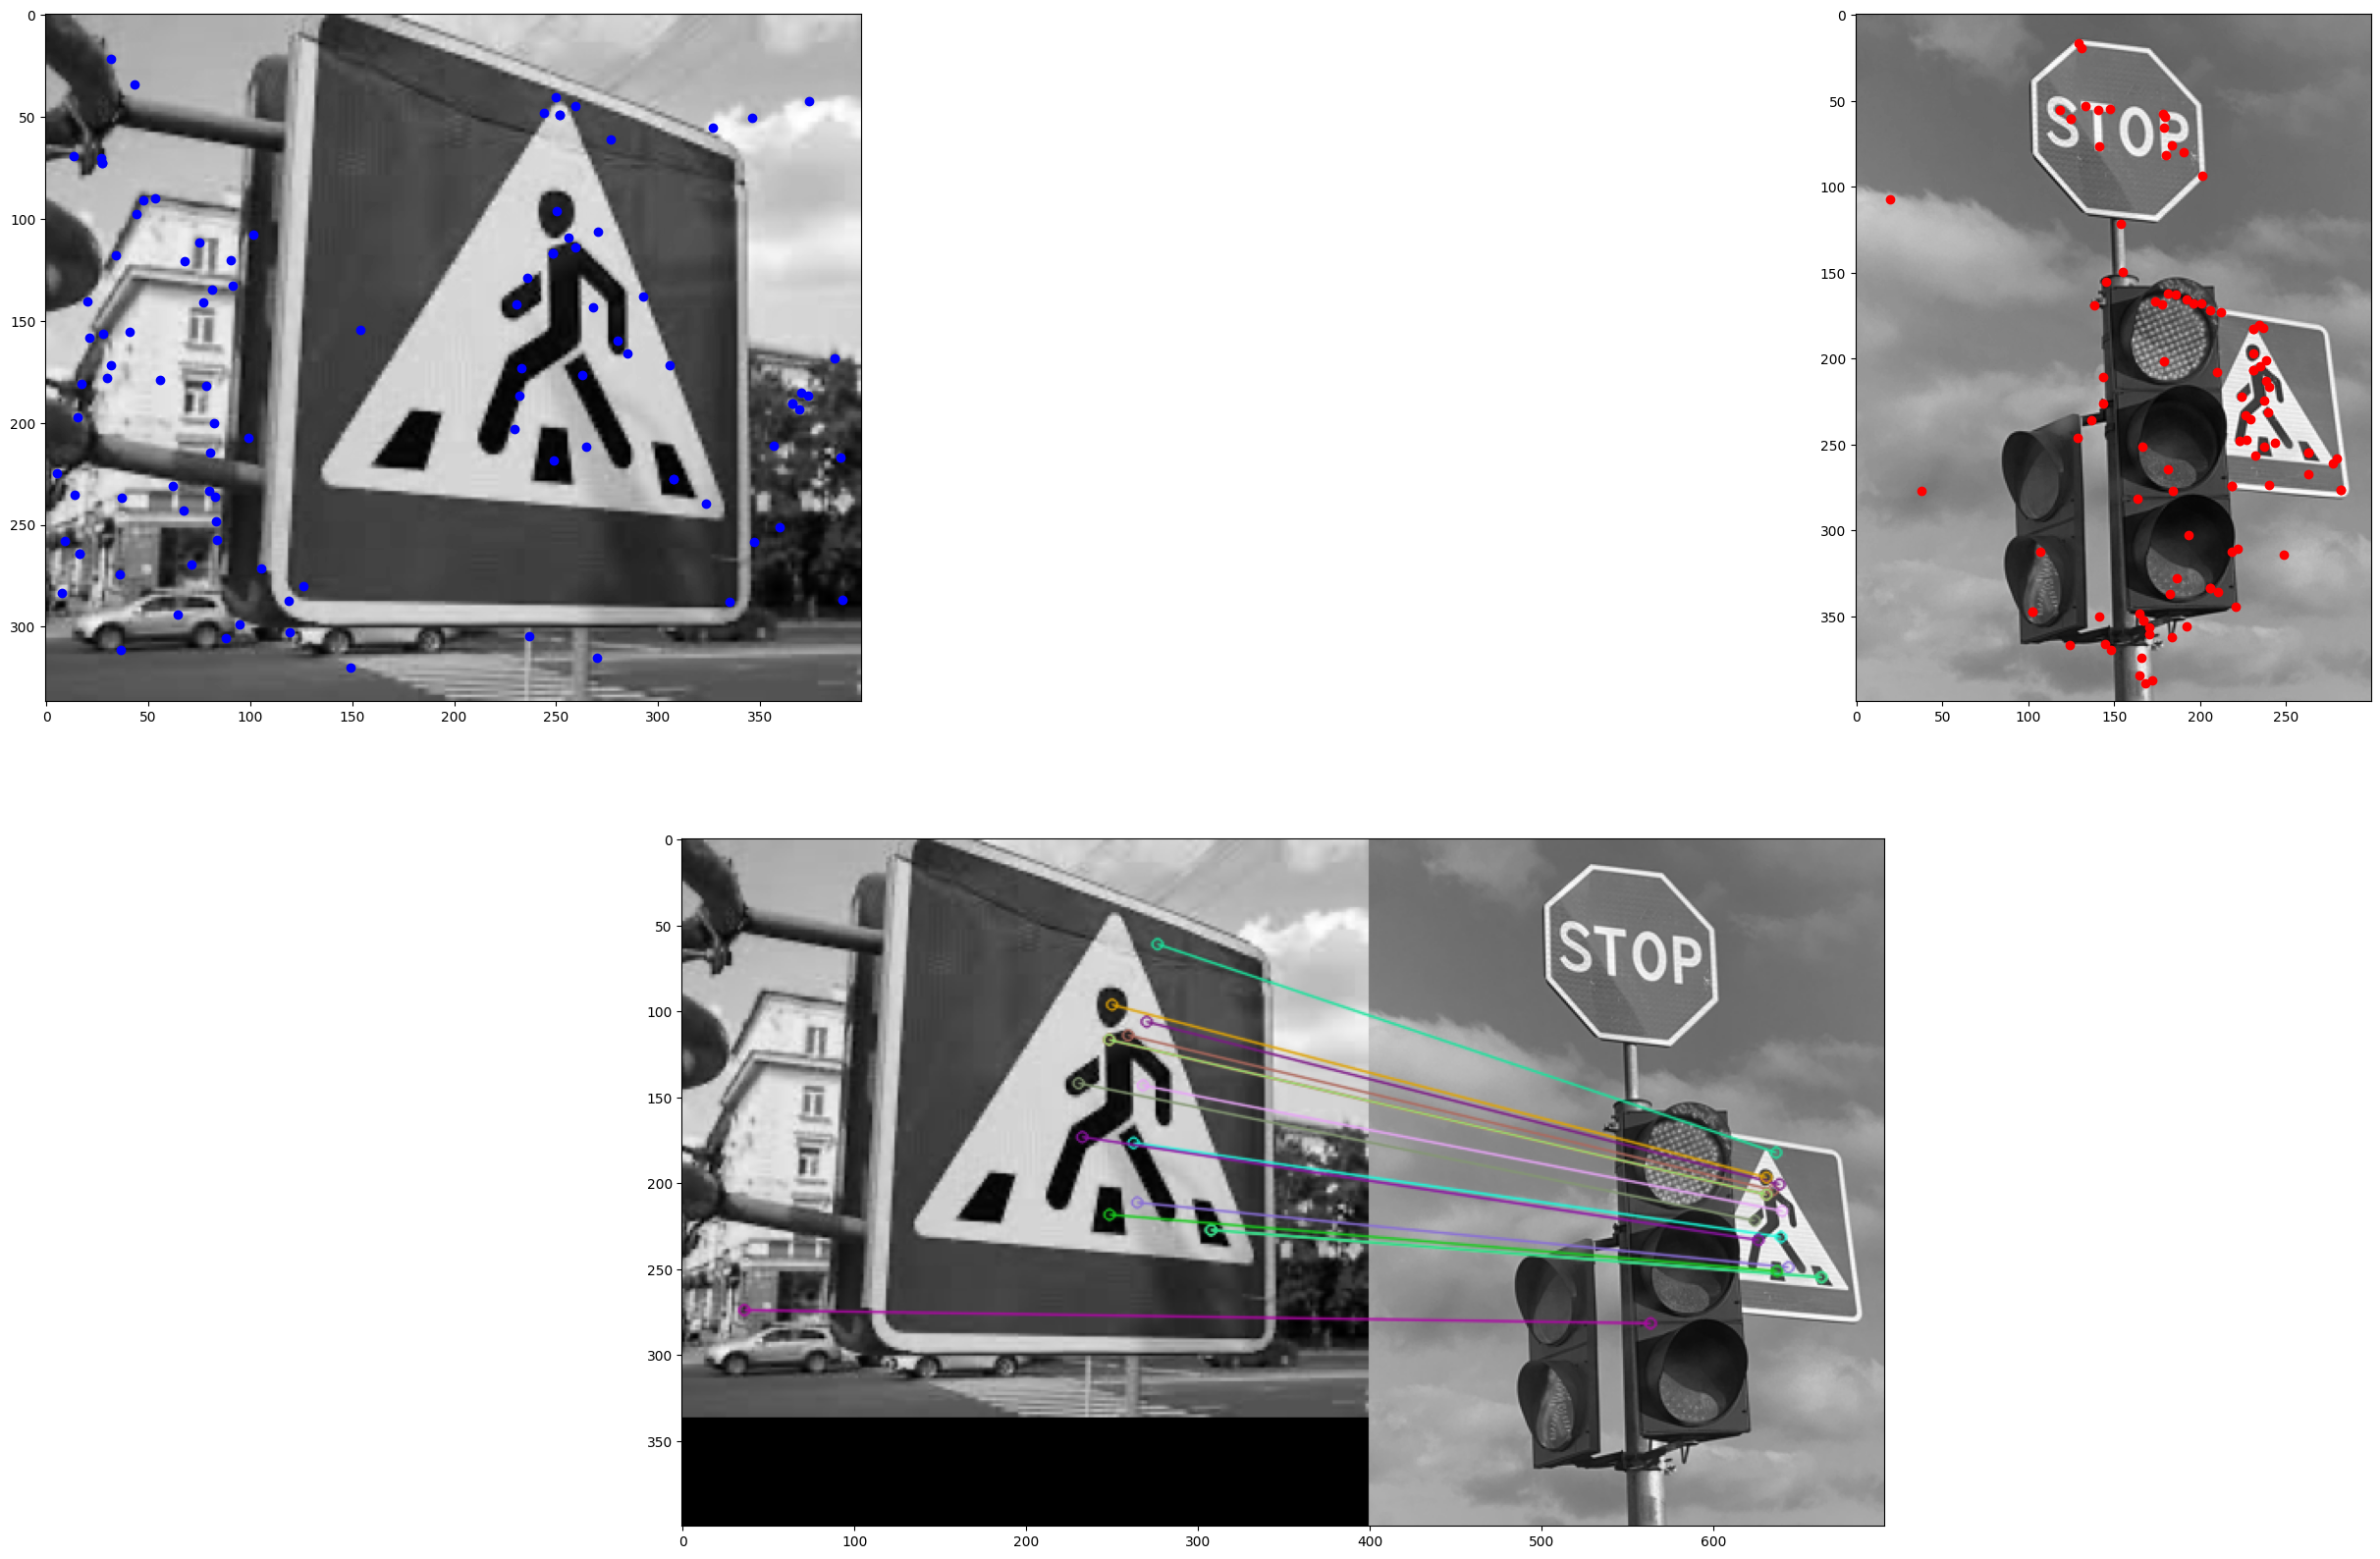

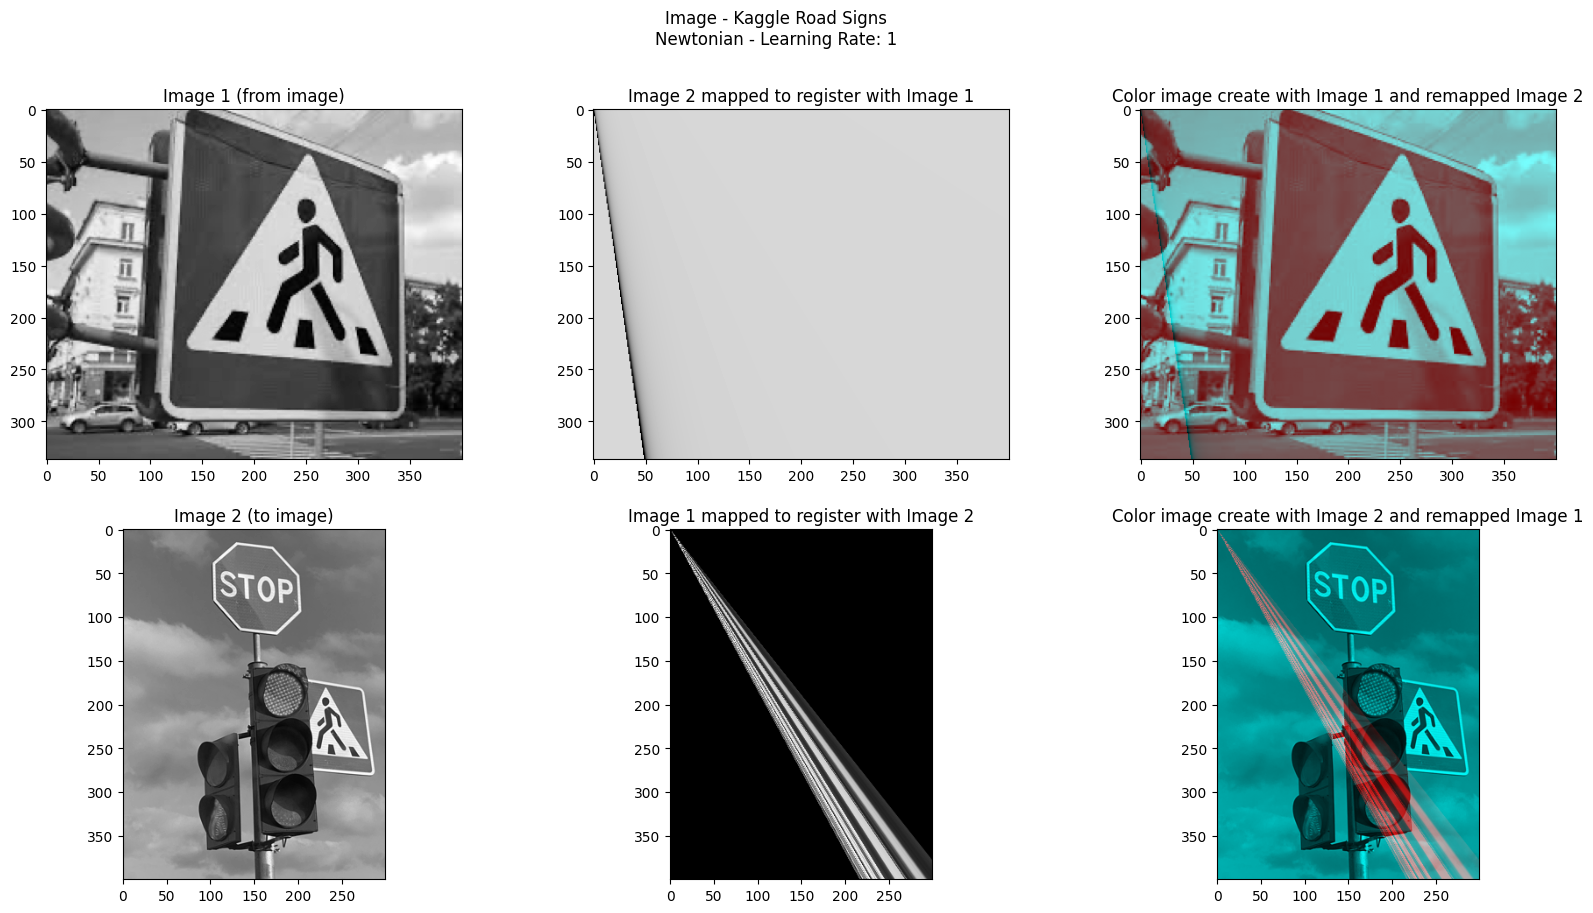

In [27]:
#image_1 = io.imread('https://i.stack.imgur.com/Er7vx.png')
#mage_2 = io.imread('https://i.stack.imgur.com/gAz96.png')

image_1 = io.imread(data_dir+'Road Signs Kaggle/images/road153.png')
image_2 = io.imread(data_dir+'Road Signs Kaggle/images/road824.png')

#image_1 = io.imread(data_dir+'kellog.jpg')
#image_2 = io.imread('https://c7.alamy.com/comp/J6T86H/boxes-of-rice-krispies-and-raisin-bran-cereal-on-shelves-at-a-grocery-J6T86H.jpg')

#image_1 = io.imread(data_dir+'Road Signs Kaggle/images/road152.png')
#image_2 = io.imread(data_dir+'Road Signs Kaggle/images/road824.png')

#image_1 = io.imread('http://mcfcrandall.files.wordpress.com/2015/11/blog_danforth_monica_mural_panorama.jpg')
#image_2 = io.imread('http://mcfcrandall.files.wordpress.com/2015/11/blog_monica_mural_fish_tree_windows1.jpg')

#image_1 = io.imread(data_dir+'mountain_peak_1.png')
#image_2 = io.imread(data_dir+'mountain_peak_2.png')

# Some frame taken from the latest video activity analysis dataset (MEVA) https://mevadata.org/
#image_1 = io.imread(data_dir+'parking_lot_meva_2.png')
#image_2 = io.imread(data_dir+'parking_lot_meva_1.png')

image_1 = cv2.cvtColor(image_1, cv2.COLOR_RGB2BGR) # change from scikit RGB to cv2 BGR format for color images
image_2 = cv2.cvtColor(image_2, cv2.COLOR_RGB2BGR)
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY) # change from color to gray
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

learning_rate = 1

image_name = 'Kaggle Road Signs'

X_1, X_2, keypoints_1, keypoints_2, matches = detect_and_match_keypoints (image_1, image_2)
top_matches = 100
X_1 = X_1[:top_matches,:]
X_2 = X_2[:top_matches,:]

#-----------call to non linear fitting function-------------------
#residual, T, matches_selected = fit_Newton_autograd (X_1, X_2)
residual, T, matches_selected = fit_grad_descent_autograd (X_1, X_2, learning_rate)

#--------------------------------------------------------------

T_inv = np.linalg.inv(T)
print('Residual error={}\n T =\n{}\n T_inv =\n{}'.format(residual, T, T_inv))

warped_1_into_2 = warp(image_1, inverse_map=T_inv, output_shape=image_2.shape)

warped_2_into_1 = warp(image_2, inverse_map=T, output_shape=image_1.shape)


#----------------------------------Display-------------------------------------------------------
# draw matches
matches_selected = (np.where(matches_selected==1)[0])
matches_selected = np.take(matches, matches_selected)
match_image = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, matches_selected, image_2, flags=2)

plt.figure(figsize=(40,20))
plt.subplot(221)
plt.imshow(image_1, 'gray')
plt.plot(X_1[:,0], X_1[:,1], 'bo')
plt.subplot(222)
plt.imshow(image_2, 'gray')
plt.plot(X_2[:,0], X_2[:,1], 'ro')
plt.subplot(212)
plt.imshow(match_image)

# build an RGB image with the registered images -- should be white if match is perfect
seq_im_1_into_2 = np.zeros((image_2.shape[0], image_2.shape[1], 3))
seq_im_1_into_2[..., 0] = warped_1_into_2
seq_im_1_into_2[..., 1] = image_2/255
seq_im_1_into_2[..., 2] = image_2/255

seq_im_2_into_1 = np.zeros((image_1.shape[0], image_1.shape[1], 3))
seq_im_2_into_1[..., 0] = warped_2_into_1
seq_im_2_into_1[..., 1] = image_1/255
seq_im_2_into_1[..., 2] = image_1/255

plt.figure(figsize = (20, 10))
plt.suptitle(f'Image - {image_name}\nNewtonian - Learning Rate: {learning_rate}')
plt.subplot(2,3,1)
plt.imshow(image_1, 'gray')
plt.title('Image 1 (from image)')

plt.subplot(2,3,2)
plt.imshow(warped_2_into_1, 'gray')
plt.title('Image 2 mapped to register with Image 1')

plt.subplot(2,3,3)
plt.imshow(seq_im_2_into_1, 'gray')
plt.title('Color image create with Image 1 and remapped Image 2')


plt.subplot(2,3,4)
plt.imshow(image_2, 'gray')
plt.title('Image 2 (to image)')

plt.subplot(2,3,5)
plt.imshow(warped_1_into_2, 'gray')
plt.title('Image 1 mapped to register with Image 2')

plt.subplot(2,3,6)
plt.imshow(seq_im_1_into_2, 'gray')
plt.title('Color image create with Image 2 and remapped Image 1')


# Assignment: Study of the sensitivity of gradient descent and Newton methods

Try the gradient descent and Newton methods-based perspective transformation estimation using PyTorch code with the images commented out.

For each, choose three different learning rates and study the quality of the fit visually and in terms of the final residual values.

Comment on the differences in quality and convergence nature of the two methods.

# 4. Miscellaneous

## 4.1 Nifty numpy code for multiple access

In [ ]:
# how to access multiple indices in a list -- from https://www.kite.com/python/answers/how-to-access-multiple-indices-of-a-list-in-python

a_list = [1, 2, 3]
indices_to_access = [0, 2]
# a_list[indices_to_access] # we cannot do this - it will throw an error!

# we first turn them into array, index, and then turn it into a list
a_numpy_array = np.array(a_list)
accessed_array = a_numpy_array[indices_to_access]
accessed_list = list(accessed_array)
print(accessed_list)